## Inisialisasi 

In [1]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

## Memuat Data

Dataset yang kamu perlukan disimpan di folder `/datasets/faces/`. Pada folder tersebut, kamu bisa menemukan: - Folder `final_file` dengan 7,6 ribu foto 
- File `labels.csv` yang memuat label, dengan dua kolom: `file_name` dan `real_age` 
Mengingat jumlah file gambar cukup banyak, kamu disarankan untuk tidak membacanya sekaligus, karena hal ini hanya akan menghabiskan sumber daya komputasi. Untuk itu, kami sarankan kamu untuk membuat generator dengan ImageDataGenerator. Metode ini telah dijelaskan sebelumnya di Bab 3, Pelajaran ke-7. 
File label bisa dimuat sebagai file CSV biasa.

In [2]:
# Memuat data
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
features, target = next(train_gen_flow)

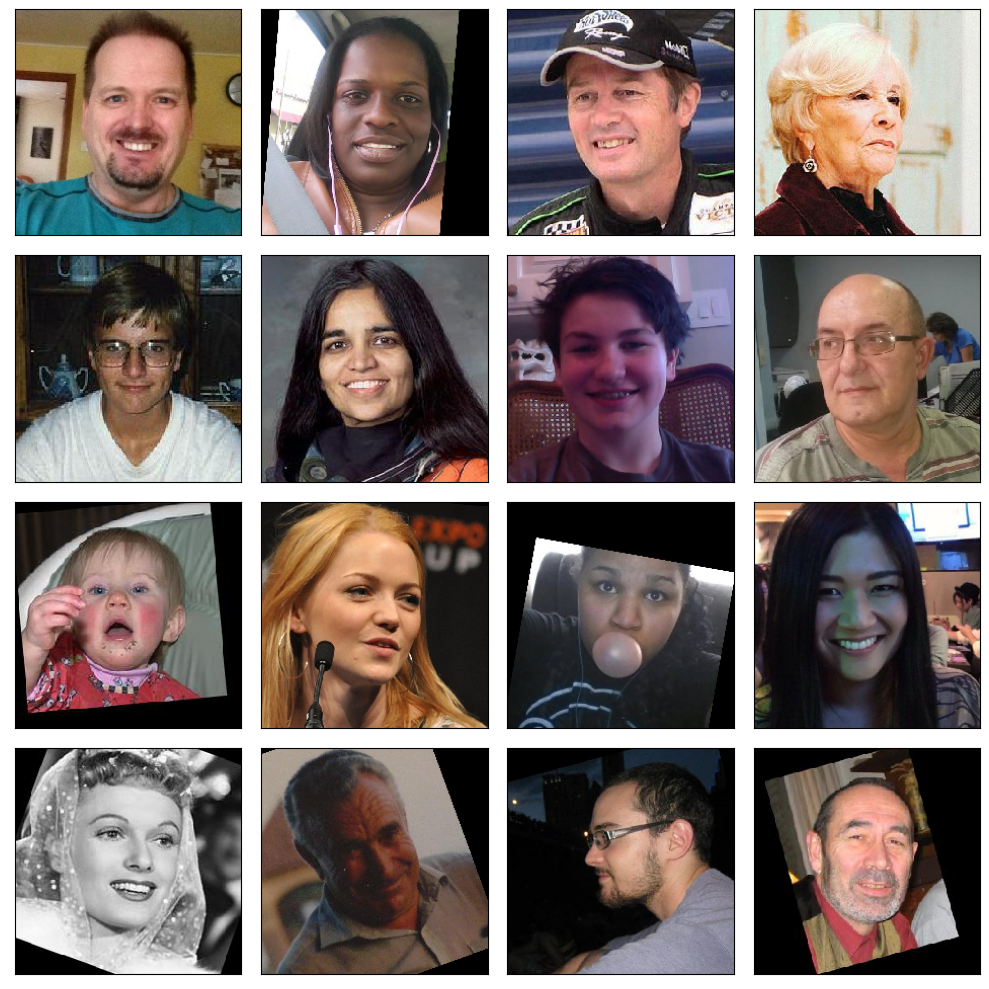

In [4]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

In [5]:
labels['real_age'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        93,  94,  95,  96,  97, 100])

<AxesSubplot:ylabel='Frequency'>

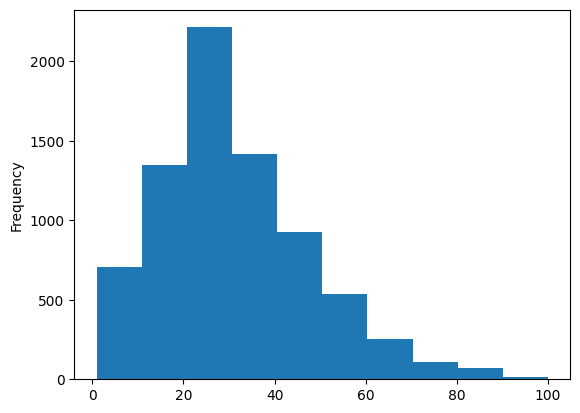

In [6]:
labels['real_age'].plot(kind='hist')

### Temuan

<div class="alert-info">
    

<b>Note</b>

- Terdapat Umur secara lengkap dari berumur 1 Tahun Hingga 100 Tahun
- Rata-rata umur pada data yang ditemukan yaitu 20-30 Tahun
- Gambar yang tersedia juga memiliki varian yang cukup banyak, mulai dari Balita - Remaja - Dewasa - Tua



## Pemodelan 

Definisikan fungsi-fungsi yang diperlukan untuk melatih modelmu pada platform GPU dan buat satu skrip yang berisi semua fungsi tersebut beserta bagian inisialisasi.
Untuk mempermudah tugas ini, kamu bisa mendefinisikannya dalam notebook ini dan menjalankan kode siap pakai di bagian berikutnya untuk menyusun skrip secara otomatis.
Oh ya, definisi di bawah ini juga akan diperiksa oleh project reviewer agar mereka bisa memahami caramu membangun model.

In [9]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [16]:
def load_train(path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True
    )
    labels= pd.read_csv('/datasets/faces/labels.csv')
    train_data = datagen.flow_from_dataframe(
        dataframe=labels ,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
        subset='training',
        seed=12345
    )
    return train_gen_flow

In [17]:
def load_test(path):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25)
    labels= pd.read_csv('/datasets/faces/labels.csv')
    test_data = datagen.flow_from_dataframe(
        dataframe=labels,  
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
        subset='validation',
        seed=12345
    )

    return test_gen_flow

In [18]:
def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(
        optimizer=Adam(lr=0.000075),
        loss='mean_squared_error',
        metrics=['mae'])
    return model

In [19]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
         validation_steps=validation_steps,
        verbose=2)
    return model

## Siapkan Skrip untuk menjalankan platform GPU

Setelah kamu mendefinisikan fungsi-fungsi yang diperlukan, kamu bisa membuat skrip untuk platform GPU, mengunduhnya melalui menu "File|Open...", dan mengunggahnya nanti untuk dijalankan pada platform GPU. "

Catatan: Skrip kamu juga harus menyertakan bagian inisialisasi. Contohnya ditunjukkan di bawah ini.

In [14]:
# siapkan skrip untuk menjalankan platform GPU


init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Letakkan output dari platform GPU sebagai sel Markdown di sini.

## Kesimpulan

<div class="alert-info">
    

<b>Note</b>

- Nilai Mean Square Error pada pelatihan menggunakan Model Resnet50 yaitu 6,5
- Dengan nilai tersebut artinya masih terdapat kemungkinan kesalahan dalam penentuan usia walaupun tidak terlalu besar yaitu .

